In [1]:
import os
raw_data_dir = ''

if  'COLAB_GPU' in os.environ:
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne
    !pip install pyedflib

    print('\n \n To load files from Google Drive, account validation is required.')
    #mount to drive -- files should be located in the Colab notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
else:
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    #declare local data directory here
    raw_data_dir = '../../Data/Raw/' 


Using homepath \Users\marit


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

import pandas as pd
import pyedflib


import tensorflow as tf
use_gpu = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)


import numpy as np

# mne imports
import mne
from mne import io

from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint


# tools for plotting confusion matrices
from matplotlib import pyplot as plt

import random 
import math



C:\Users\marit\Anaconda3\lib\site-packages\numba\decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [53]:
#### Get all raw data

from IPython.display import Markdown, display

# edf libraries
import pyedflib
import mne

#pca dependencies
from sklearn import decomposition

ignore_list = ['s07']  #list of patient files that should be skipped

import pyedflib
mne.set_log_level("WARNING")

# get the minimum length of the files
def get_minimum_duration(group_directory_name, patient_group_file_prefix):
    file_durations = []
    for i in range (1, 15): # reading 14 files
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        file_name = raw_data_dir + '{}/{}.edf'.format(group_directory_name, patient_id)
        f = pyedflib.EdfReader(file_name)
        file_durations.append(f.file_duration)
        f.close()
    return(min(file_durations))



# modified based on https://stackoverflow.com/a/48704557/2466781
def chunk(seq, size):
    sl = len(seq) - (len(seq)%size) #exclude values that will be out of range
    r = [pd.DataFrame(seq[pos:pos + size]) for pos in range(0, sl, size)]
    return r

    
    
def process_patient_group(group_directory_name, patient_group_file_prefix, 
                          minimum_original_duration, 
                          time_window,
                          channels = ['F8', 'F7', 'F4', 'F3', 'Fz']):
    patient_data = pd.DataFrame()
    patient_id_list = []
    for i in range (1, 15): # reading 14 files
        patient_df = []
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        patient_id_list.append(patient_id)
        
        file_name = raw_data_dir + '{}/{}.edf'.format(group_directory_name, patient_id)
        data = mne.io.read_raw_edf(file_name)
        df = data.to_data_frame()
        ## drop the first 120 seconds and last 120 seconds
        df2 = df[channels]
        df2 = df2[120: (minimum_original_duration-120)]
        if patient_id not in ignore_list:
            patient_data = patient_data.append(df2)
           
        
    batches = chunk(patient_data, time_window)
    meta = []
    for batch in batches:
        meta.append([np.asarray(batch.values)])
           
            
    return meta



#
all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
target_channels = ['T4', 'T6', 'O2', 'T3', 'T5', 'O1',
                  'C4', 'P4', 'C3', 'P3', 'Cz', 'Pz']

minimum_duration = min(get_minimum_duration("Healthy Controls", "h"), get_minimum_duration('SZ Patients', 's'))
print('Retrieving raw data....')
print('Minimum file duration: {} seconds'.format( minimum_duration))
print("Healthy Controls:")
time_window = 12
hc_data_all = np.asarray(process_patient_group('Healthy Controls', 'h', minimum_duration, time_window=time_window, 
                                               channels=target_channels), dtype=np.float32)
print(np.asarray(hc_data_all).shape)


print('Sz Patients:')
sz_data_all = np.asarray(process_patient_group('SZ Patients', 's', minimum_duration, time_window=time_window,
                                              channels=target_channels), dtype=np.float32)
print(np.asarray(sz_data_all).shape)


###



Retrieving raw data....
Minimum file duration: 740 seconds
Healthy Controls:
(583, 1, 12, 12)
Sz Patients:
(541, 1, 12, 12)


In [54]:
#drop the second dimension
hcds = np.asarray(hc_data_all).shape
hc_data_all = hc_data_all.reshape(hcds[0], hcds[2], hcds[3])
szds = np.asarray(sz_data_all).shape
sz_data_all = sz_data_all.reshape(szds[0], szds[2], szds[3])


In [55]:
def select_denoised_data(patient_data):
    all_features = []
  
    
    for entry in patient_data:
        sample_features = []
        pca_denoise = decomposition.PCA(n_components=12)
        pca_denoise.fit(entry)
        denoised_data = pca_denoise.components_
        
        all_features.append(np.asarray(denoised_data)) 
        

    return all_features
    

sample_size = minimum_duration #use entire window
#send all channels and all patient data; s07 is still skipped
hc_data_all_denoised_selected = select_denoised_data(hc_data_all)
sz_data_all_denoised_selected = select_denoised_data(sz_data_all)

print('Shape of denoised data (extracted components) :')
print(np.asarray(hc_data_all_denoised_selected).shape)
print(np.asarray(sz_data_all_denoised_selected).shape)

Shape of denoised data (extracted components) :
(583, 12, 12)
(541, 12, 12)


In [56]:
#setup the network
from tensorflow.keras import layers
#https://www.tensorflow.org/guide/keras/rnn

def LSTM(samples, time_steps, nb_features, chans, nb_classes):

    model=tf.keras.Sequential()
    
    model.add(layers.LSTM(256,
                          input_shape=(chans, time_steps)
            #input_shape=(chans* nb_features, time_steps),
            ))

    model.add(Dense(32,kernel_initializer='he_uniform',activation='relu'))

    model.add(Dense(nb_classes,activation='softmax'))
    
    return model

In [57]:
X =  np.concatenate((hc_data_all_denoised_selected, sz_data_all_denoised_selected), axis=0)
print('Input size: ', X.shape)
y = ([0] * len(hc_data_all)) +( [1] * len(sz_data_all))


Input size:  (1124, 12, 12)


Input (X) shape: (1124, 12, 12)
Preview of data. First sample of extracted and cleaned data  (12, 12)


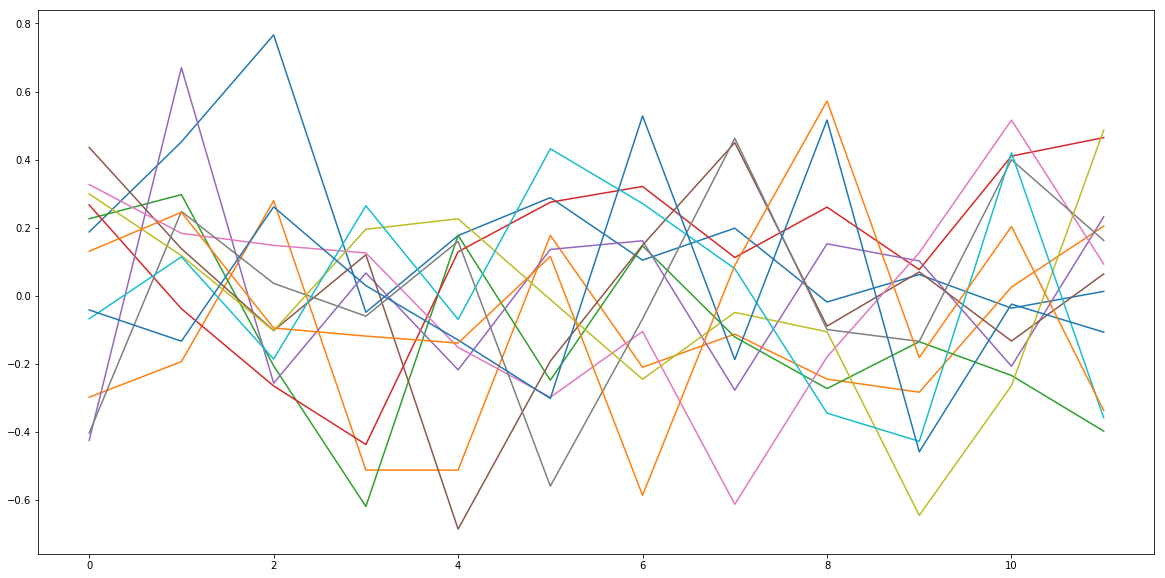

In [58]:
#X[1].plot()
from IPython.display import display

import pylab as pylab
plt.figure(figsize=(20,10))

print('Input (X) shape: ' + str(X.shape))
print('Preview of data. First sample of extracted and cleaned data ', X[0].shape )
for el in X[0]:
    #print(el)
    #pylab.scatter(x=range(len(el)), y=el)
    pylab.plot(el)


In [59]:
#### Create the /tmp directory if it doesn't already exist
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')



In [60]:
# get a list of randomly selected sets of numbers based on a range
# the proportion of values selected for each set is determined by the ratio_array
def get_mixed_indexes_for_ml_train_test(length, ratios_array):
    input_indexes = range(0, length)
    output_indexes = []
    for ratio in ratios_array:
        selection = random.choices(input_indexes, k=math.floor(ratio * length))
        input_indexes = [i for i in input_indexes if i not in selection]
        output_indexes.append(selection)
    return output_indexes
    

feature_count = 1 # just extracted PCA
train_idxs, validate_idxs, test_idxs = get_mixed_indexes_for_ml_train_test(len(X), [.70, 0.15, 0.15])

# declare training, validation and test sets
X_train      = X[train_idxs][0:,]
Y_train      = np.asarray(y)[train_idxs]
X_validate   = X[validate_idxs][0:,]
Y_validate   = np.asarray(y)[validate_idxs]
X_test       = X[test_idxs][0:,]
Y_test       = np.asarray(y)[test_idxs]


# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train, num_classes=2)
Y_validate   = np_utils.to_categorical(Y_validate, num_classes=2)
Y_test       = np_utils.to_categorical(Y_test, num_classes=2)


# convert data to NHWC (trials, channels, samples, kernels) format.  for CPU. 
#X_train      = X_train.reshape(X_train.shape[0],  chans, samples, feature_count)
X_train      = X_train.reshape(X_train.shape[0],  chans, samples)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples)
X_test       = X_test.reshape(X_test.shape[0], chans, samples)

    
print('X_train shape:', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


ValueError: cannot reshape array of size 113184 into shape (786,12,20)

In [44]:
time_steps = time_window #sample_size #seconds of data to include in one slice


print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')


model = LSTM(samples=samples, time_steps=time_steps, chans=chans, nb_features=1, nb_classes=2, )
model.summary()

#import tensorflow 
import tensorflow.keras.optimizers
opt_adam = tensorflow.keras.optimizers.Adam(lr=0.000001, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)
sgd = tensorflow.keras.optimizers.SGD(lr=0.01)



def rmse (y_true, y_pred):

    return K.sqrt(K.mean(K.square(y_pred -y_true)))



# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer=opt_adam, 
              metrics=[#'mse', 'mae', 
                  'accuracy', rmse
                 ])


# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/LSTM_checkpoint.h5', verbose=1,
                               save_best_only=True)
print(X_train.shape)
print(Y_train.shape)
fitted_model = model.fit(X_train, Y_train, batch_size = 32, epochs = 300, 
                    verbose = 2, validation_data=(X_validate, Y_validate),
                    callbacks=[checkpointer])#, class_weight = class_weights)




X_train shape: (472, 12, 20)
472 train samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 256)               283648    
_________________________________________________________________
dense_14 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 66        
Total params: 291,938
Trainable params: 291,938
Non-trainable params: 0
_________________________________________________________________
(472, 12, 20)
(472, 2)
Train on 472 samples, validate on 101 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 0.69601, saving model to /tmp/LSTM_checkpoint.h5
 - 4s - loss: 0.6935 - acc: 0.4555 - rmse: 0.5002 - val_loss: 0.6960 - val_acc: 0.4752 - val_rmse: 0.5010
Epoch 2/300

Epoch 00002: val_loss improved from 0.69601 to 0.69601, savi

Epoch 36/300

Epoch 00036: val_loss improved from 0.69597 to 0.69596, saving model to /tmp/LSTM_checkpoint.h5
 - 1s - loss: 0.6924 - acc: 0.4958 - rmse: 0.4996 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.4995
Epoch 37/300

Epoch 00037: val_loss improved from 0.69596 to 0.69596, saving model to /tmp/LSTM_checkpoint.h5
 - 1s - loss: 0.6923 - acc: 0.5000 - rmse: 0.4996 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.5021
Epoch 38/300

Epoch 00038: val_loss improved from 0.69596 to 0.69596, saving model to /tmp/LSTM_checkpoint.h5
 - 1s - loss: 0.6923 - acc: 0.5021 - rmse: 0.4996 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.5002
Epoch 39/300

Epoch 00039: val_loss improved from 0.69596 to 0.69596, saving model to /tmp/LSTM_checkpoint.h5
 - 1s - loss: 0.6923 - acc: 0.5021 - rmse: 0.4996 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.5026
Epoch 40/300

Epoch 00040: val_loss improved from 0.69596 to 0.69596, saving model to /tmp/LSTM_checkpoint.h5
 - 1s - loss: 0.6922 - acc


Epoch 00076: val_loss did not improve from 0.69595
 - 1s - loss: 0.6911 - acc: 0.5275 - rmse: 0.4989 - val_loss: 0.6959 - val_acc: 0.5050 - val_rmse: 0.5021
Epoch 77/300

Epoch 00077: val_loss did not improve from 0.69595
 - 1s - loss: 0.6910 - acc: 0.5297 - rmse: 0.4989 - val_loss: 0.6959 - val_acc: 0.5050 - val_rmse: 0.5002
Epoch 78/300

Epoch 00078: val_loss did not improve from 0.69595
 - 1s - loss: 0.6910 - acc: 0.5297 - rmse: 0.4989 - val_loss: 0.6960 - val_acc: 0.5050 - val_rmse: 0.4999
Epoch 79/300

Epoch 00079: val_loss did not improve from 0.69595
 - 1s - loss: 0.6910 - acc: 0.5297 - rmse: 0.4989 - val_loss: 0.6960 - val_acc: 0.5050 - val_rmse: 0.5020
Epoch 80/300

Epoch 00080: val_loss did not improve from 0.69595
 - 1s - loss: 0.6909 - acc: 0.5360 - rmse: 0.4989 - val_loss: 0.6960 - val_acc: 0.5050 - val_rmse: 0.5022
Epoch 81/300

Epoch 00081: val_loss did not improve from 0.69595
 - 1s - loss: 0.6909 - acc: 0.5360 - rmse: 0.4989 - val_loss: 0.6960 - val_acc: 0.5050 - val_

Epoch 124/300

Epoch 00124: val_loss did not improve from 0.69595
 - 1s - loss: 0.6895 - acc: 0.5911 - rmse: 0.4982 - val_loss: 0.6960 - val_acc: 0.4851 - val_rmse: 0.5007
Epoch 125/300

Epoch 00125: val_loss did not improve from 0.69595
 - 1s - loss: 0.6895 - acc: 0.5911 - rmse: 0.4982 - val_loss: 0.6960 - val_acc: 0.4752 - val_rmse: 0.5016
Epoch 126/300

Epoch 00126: val_loss did not improve from 0.69595
 - 1s - loss: 0.6894 - acc: 0.5932 - rmse: 0.4982 - val_loss: 0.6960 - val_acc: 0.4752 - val_rmse: 0.5025
Epoch 127/300

Epoch 00127: val_loss did not improve from 0.69595
 - 1s - loss: 0.6894 - acc: 0.5932 - rmse: 0.4981 - val_loss: 0.6960 - val_acc: 0.4752 - val_rmse: 0.5013
Epoch 128/300

Epoch 00128: val_loss did not improve from 0.69595
 - 1s - loss: 0.6894 - acc: 0.5953 - rmse: 0.4981 - val_loss: 0.6960 - val_acc: 0.4851 - val_rmse: 0.5022
Epoch 129/300

Epoch 00129: val_loss did not improve from 0.69595
 - 2s - loss: 0.6894 - acc: 0.5975 - rmse: 0.4981 - val_loss: 0.6960 - val

Epoch 172/300

Epoch 00172: val_loss did not improve from 0.69595
 - 2s - loss: 0.6880 - acc: 0.6208 - rmse: 0.4974 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.5006
Epoch 173/300

Epoch 00173: val_loss did not improve from 0.69595
 - 1s - loss: 0.6880 - acc: 0.6208 - rmse: 0.4974 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.5022
Epoch 174/300

Epoch 00174: val_loss did not improve from 0.69595
 - 1s - loss: 0.6879 - acc: 0.6208 - rmse: 0.4974 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.5021
Epoch 175/300

Epoch 00175: val_loss did not improve from 0.69595
 - 1s - loss: 0.6879 - acc: 0.6208 - rmse: 0.4973 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.5012
Epoch 176/300

Epoch 00176: val_loss did not improve from 0.69595
 - 2s - loss: 0.6879 - acc: 0.6208 - rmse: 0.4973 - val_loss: 0.6960 - val_acc: 0.4950 - val_rmse: 0.5024
Epoch 177/300

Epoch 00177: val_loss did not improve from 0.69595
 - 1s - loss: 0.6878 - acc: 0.6208 - rmse: 0.4973 - val_loss: 0.6960 - val

Epoch 220/300

Epoch 00220: val_loss did not improve from 0.69595
 - 2s - loss: 0.6864 - acc: 0.6504 - rmse: 0.4966 - val_loss: 0.6960 - val_acc: 0.4851 - val_rmse: 0.5021
Epoch 221/300

Epoch 00221: val_loss did not improve from 0.69595
 - 2s - loss: 0.6864 - acc: 0.6504 - rmse: 0.4965 - val_loss: 0.6960 - val_acc: 0.4851 - val_rmse: 0.5020
Epoch 222/300

Epoch 00222: val_loss did not improve from 0.69595
 - 2s - loss: 0.6863 - acc: 0.6504 - rmse: 0.4966 - val_loss: 0.6960 - val_acc: 0.4851 - val_rmse: 0.5003
Epoch 223/300

Epoch 00223: val_loss did not improve from 0.69595
 - 1s - loss: 0.6863 - acc: 0.6504 - rmse: 0.4966 - val_loss: 0.6960 - val_acc: 0.4851 - val_rmse: 0.5013
Epoch 224/300

Epoch 00224: val_loss did not improve from 0.69595
 - 1s - loss: 0.6863 - acc: 0.6504 - rmse: 0.4966 - val_loss: 0.6960 - val_acc: 0.4851 - val_rmse: 0.5015
Epoch 225/300

Epoch 00225: val_loss did not improve from 0.69595
 - 1s - loss: 0.6862 - acc: 0.6504 - rmse: 0.4965 - val_loss: 0.6960 - val

Epoch 268/300

Epoch 00268: val_loss did not improve from 0.69595
 - 1s - loss: 0.6849 - acc: 0.6631 - rmse: 0.4959 - val_loss: 0.6960 - val_acc: 0.4554 - val_rmse: 0.5002
Epoch 269/300

Epoch 00269: val_loss did not improve from 0.69595
 - 1s - loss: 0.6849 - acc: 0.6631 - rmse: 0.4958 - val_loss: 0.6960 - val_acc: 0.4554 - val_rmse: 0.5009
Epoch 270/300

Epoch 00270: val_loss did not improve from 0.69595
 - 1s - loss: 0.6848 - acc: 0.6631 - rmse: 0.4958 - val_loss: 0.6959 - val_acc: 0.4554 - val_rmse: 0.5025
Epoch 271/300

Epoch 00271: val_loss did not improve from 0.69595
 - 1s - loss: 0.6848 - acc: 0.6631 - rmse: 0.4958 - val_loss: 0.6959 - val_acc: 0.4554 - val_rmse: 0.5017
Epoch 272/300

Epoch 00272: val_loss did not improve from 0.69595
 - 2s - loss: 0.6848 - acc: 0.6631 - rmse: 0.4958 - val_loss: 0.6959 - val_acc: 0.4554 - val_rmse: 0.4992
Epoch 273/300

Epoch 00273: val_loss improved from 0.69595 to 0.69595, saving model to /tmp/LSTM_checkpoint.h5
 - 1s - loss: 0.6847 - acc: 0

In [10]:
print('Mean of Metrics for All Iterations \n')
print('Train Accuracy: {0:.2f}% '.format(np.mean(log_train_accuracy) * 100))
print('Validation Accuracy: {0:.2f}% '.format(np.mean(log_validation_accuracy) * 100))
print('Train RMSE: {0:.2f} '.format(np.mean(log_train_rmse)))
print('Validation RMSE: {0:.2f} '.format(np.mean(log_validation_rmse)))
print('Train Loss: {0:.2f} '.format(np.mean(log_train_loss)))
print('Validation Loss: {0:.2f} '.format(np.mean(log_validation_loss)))

Mean of Metrics for All Iterations 

Train Accuracy: 72.51% 
Validation Accuracy: 51.85% 
Train RMSE: 0.50 
Validation RMSE: 0.50 
Train Loss: 0.69 
Validation Loss: 0.69 


Diagrammed History of Model Metrics


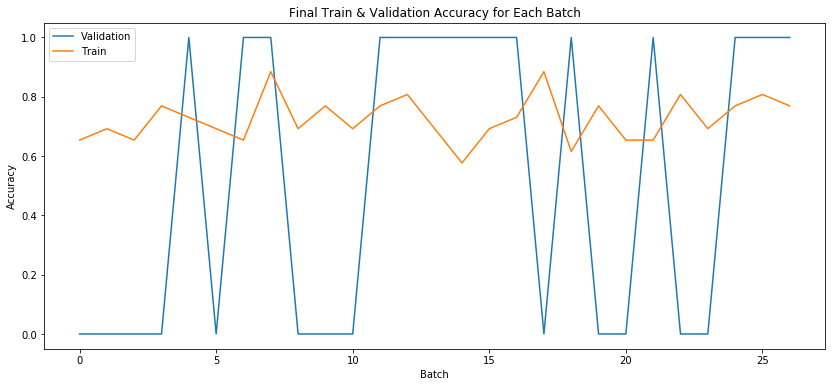

In [11]:
# list all data in history
# print(fitted_model.history.keys())

print('Diagrammed History of Model Metrics')

plt.figure(figsize=(14,6))
plt.plot(log_validation_accuracy)
plt.plot(log_train_accuracy)
plt.title('Final Train & Validation Accuracy for Each Batch')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()



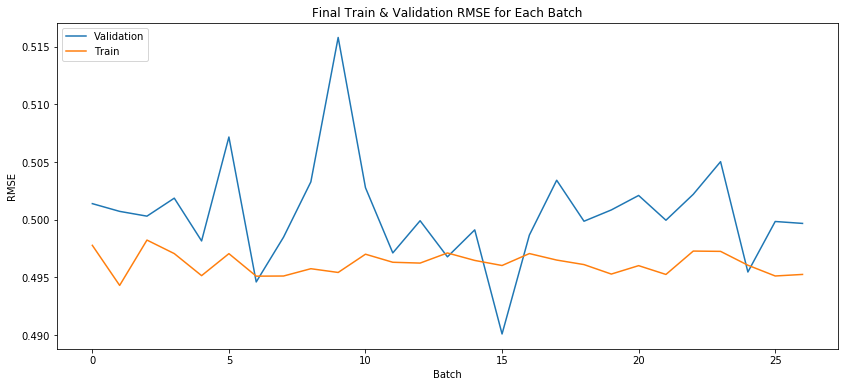

In [12]:
# summarize rmse
plt.figure(figsize=(14,6))
plt.plot(log_validation_rmse)
plt.plot(log_train_rmse)
plt.title('Final Train & Validation RMSE for Each Batch')
plt.ylabel('RMSE')
plt.xlabel('Batch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

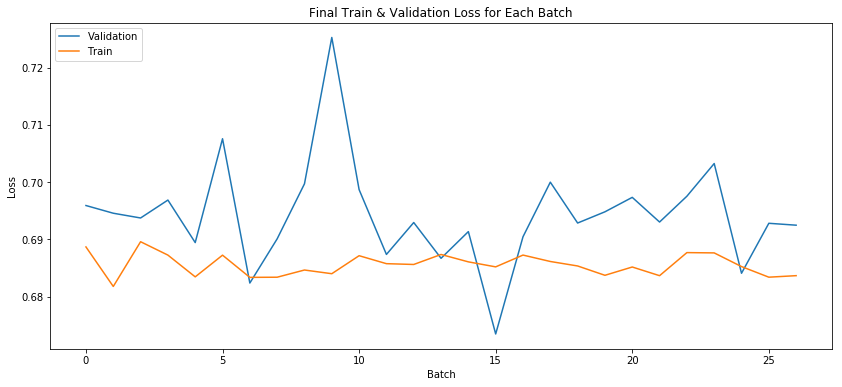

In [13]:
# summarize loss 
plt.figure(figsize=(14,6))
plt.plot(log_validation_loss)
plt.plot(log_train_loss)
plt.title('Final Train & Validation Loss for Each Batch')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.legend(['Validation', 'Train'], loc='upper left')
plt.show()

In [14]:
!pip freeze

absl-py==0.7.1
alabaster==0.7.12
altgraph==0.16.1
anaconda-client==1.7.2
anaconda-navigator==1.9.6
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.8.0
astroid==2.1.0
astropy==3.1
atomicwrites==1.2.1
attrs==18.2.0
Babel==2.6.0
backcall==0.1.0
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==3.0.2
blis==0.2.4
bokeh==1.0.2
boto==2.49.0
boto3==1.9.169
botocore==1.12.169
Bottleneck==1.2.1
cachetools==3.1.1
certifi==2018.11.29
cffi==1.11.5
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
clyent==1.2.2
colorama==0.4.1
colorlover==0.3.0
comtypes==1.1.7
conda==4.5.12
conda-build==3.17.6
conda-verify==3.1.1
contextlib2==0.5.5
cryptography==2.4.2
cufflinks==0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.2
cytoolz==0.9.0.1
dask==1.0.0
datashape==0.5.4
decorator==4.3.0
defusedxml==0.5.0
distributed==1.25.1
docutils==0.14
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==3.0.10
Flask==1.0.2
Flask-Cors

In [15]:
from platform import python_version

print(python_version())

3.7.1
